## Постановка задачи
Загрузим подготовленные данные из HDF5.

Разделим данные на обучающие и проверочные в соотношении 80/20.

Используем Keras для построения нейросети с линейным, сверточными слоями и слоями подвыборки. Проверим, какая конфигурация работает лучше линейных слоев.

Проведем оценку качества предсказания по коэффициенту сходства.

Данные:
* https://video.ittensive.com/machine-learning/clouds/train.csv.gz (54 Мб)
* https://video.ittensive.com/machine-learning/clouds/train_images_small.tar.gz (212 Мб)

Соревнование: https://www.kaggle.com/c/understanding_cloud_organization/

© ITtensive, 2020

### Подключение библиотек

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from skimage import io
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"
os.environ["PATH"] += (os.pathsep +
                       'C:/Program Files (x86)/Graphviz2.38/bin/')

Using TensorFlow backend.


### Используемые функции

In [2]:
labels = ["Fish", "Flower", "Gravel", "Sugar"]
image_x = 525
image_y = 350
image_ch = 3
def mask_rate (a, x, y):
    b = a//1400 + 0.0
    return np.round(x*(b*x//2100) + y*(a%1400)//1400).astype("uint32")

def calc_mask (px, x=image_x, y=image_y):
    p = np.array([int(n) for n in px.split(' ')]).reshape(-1,2)
    mask = np.zeros(x*y, dtype='uint8')
    for i, l in p:
        mask[mask_rate(i, x, y) - 1:mask_rate(l+i, x, y)] = 1
    return mask.reshape(y,x).transpose()

def calc_dice (x):
    dice = 0
    px = x["EncodedPixels"] 
    if px != px and x["target"] == 0:
        dice = 1
    elif px == px and x["target"] == 1:
        mask = calc_mask(px).flatten()
        target = np.ones(image_x*image_y, dtype='uint8')
        dice += 2*np.sum(target[mask==1])/(np.sum(target)+np.sum(mask))
    return dice

### Загрузка данных

In [3]:
data = pd.read_csv('https://video.ittensive.com/machine-learning/clouds/train.csv.gz')

In [4]:
data["Image"] = data["Image_Label"].str.split("_").str[0]
data["Label"] = data["Image_Label"].str.split("_").str[1]
data.drop(labels=["Image_Label"], axis=1, inplace=True)
data_fish = data[data["Label"] == "Fish"]
print (data_fish.head())

                                        EncodedPixels        Image Label
0   264918 937 266318 937 267718 937 269118 937 27...  0011165.jpg  Fish
4   233813 878 235213 878 236613 878 238010 881 23...  002be4f.jpg  Fish
8   3510 690 4910 690 6310 690 7710 690 9110 690 1...  0031ae9.jpg  Fish
12                                                NaN  0035239.jpg  Fish
16  2367966 18 2367985 2 2367993 8 2368002 62 2369...  003994e.jpg  Fish


### Разделение данных
Разделим всю выборку на 2 части случайным образом: 80% - для обучения модели, 20% - для проверки точности модели.

In [5]:
train, test = train_test_split(data_fish, test_size=0.2)
train = pd.DataFrame(train)
test = pd.DataFrame(test)
del data
print (train.head())

                                           EncodedPixels        Image Label
5164   910620 88 910709 3 910713 2 910721 4 910729 16...  3b88744.jpg  Fish
22008                                                NaN  fdfa5e1.jpg  Fish
7568                                                 NaN  56609dc.jpg  Fish
19348  66063 663 67463 663 68863 663 70263 663 71663 ...  dfd58e9.jpg  Fish
13120  13653 267 15053 267 16453 267 17853 267 19253 ...  9545812.jpg  Fish


### Сверточная нейросеть
Подготовим данные для обучения нейросети: будем загружать данные пакетами. Создадим функции для загрузки двух типов данных: графических из изображения и типа облака на изображении.

In [12]:
def load_y (df):
    return np.array(df["EncodedPixels"].notnull().astype("int8")).reshape(-1,1)

def load_x (df):
    x = [[]]*len(df)
    for j, file in enumerate(df["Image"]):
        x[j] = io.imread(os.path.join(filesDir, file))
    return np.array(x).reshape(len(df), image_y, image_x, image_ch)

def load_data (df, batch_size):
    while True:
        batch_start = 0
        batch_end = batch_size
        while batch_start < len(df):
            limit = min(batch_end, len(df))
            yield (load_x(df[batch_start:limit]),
                  load_y(df[batch_start:limit]))
            batch_start += batch_size
            batch_end += batch_size

Сверточный слой (Conv2D) применяет ядро преобразования (набор математических операций) к области исходного изображения (набора входов с предыдущего слоя) для выделения особенностей (например, определенных фигур - линий или уголков). Принимает в качестве входной формы только двумерные изображения и число цветовых каналов (трехмерный массив данных на 1 изображение).
![](conv2d.png)
Сверточный слой "размноживает" исходное изображение: используется заданное (большое) число ядер свертки, которые оптимизируются на этапе обучения нейросети. Поэтому к полученным при свертке данным обычно применяют слой подвыборки (MaxPooling): выделяют самый значимый из квадрата 2x2 или 3x3 элемент, обнаруженный на сверточной слое, чтобы снизить число выходов и ускорить обучение нейросети.
![](maxpooling.png)
Свертку осуществляем с шагом (strides) 2.

На выходе слоя подвыборки находится двумерный массив нейронов, полученный выборкой из множества преобразований исходного изображения, поэтому его нужно переформировать, перевести в одномерный. Для этого используется плоский слой (Flatten).

In [7]:
model = Sequential([
    Conv2D(32, (3,3), input_shape=(image_y, image_x, image_ch),
          strides=(2,2)),
    Activation("relu"),
    Conv2D(32, (3,3), strides=(2,2)),
    Activation("relu"),
    MaxPooling2D(pool_size=(2,2)),
    Flatten(),
    Activation("softmax"),
    Dense(1)
])

### Топология модели
Потребуется graphviz
![](ml0041.png)

In [8]:
keras.utils.plot_model(model, to_file="ml0041.png",
                show_shapes=True, show_layer_names=True, rankdir="TB")

In [9]:
filesDir = "train_images_small"
batch_size = 20

Построим и обучим модель, используя адаптивный градиентный спуск и абсолютную ошибку.

In [10]:
model.compile(optimizer="adam", loss="mean_absolute_error")

In [13]:
model.fit_generator(load_data(train, batch_size),
    epochs=100, steps_per_epoch=len(train)//batch_size, verbose=True)

Epoch 1/100
221/221 [==============================] - 302s 1s/step - loss: 0.4999
Epoch 2/100
221/221 [==============================] - 329s 1s/step - loss: 0.4935
Epoch 3/100
221/221 [==============================] - 284s 1s/step - loss: 0.4858
Epoch 4/100
221/221 [==============================] - 281s 1s/step - loss: 0.4789
Epoch 5/100
221/221 [==============================] - 284s 1s/step - loss: 0.4699
Epoch 6/100
221/221 [==============================] - 316s 1s/step - loss: 0.4618
Epoch 7/100
221/221 [==============================] - 298s 1s/step - loss: 0.4533
Epoch 8/100
221/221 [==============================] - 305s 1s/step - loss: 0.4446
Epoch 9/100
221/221 [==============================] - 283s 1s/step - loss: 0.4371
Epoch 10/100
221/221 [==============================] - 264s 1s/step - loss: 0.4279
Epoch 11/100
221/221 [==============================] - 292s 1s/step - loss: 0.4211
Epoch 12/100
221/221 [==============================] - 270s 1s/step - loss: 0.4117
E

### Предсказание значений

In [14]:
prediction = model.predict_generator(load_data(test, 1),
                            steps=len(test), verbose=1)

1110/1110 [==============================] - 45s 40ms/step


In [15]:
def draw_prediction (prediction):
    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(1,1,1)
    ax.hist(prediction[0])
    ax.set_title("Fish")
    plt.show()

In [16]:
prediction = np.transpose(prediction)

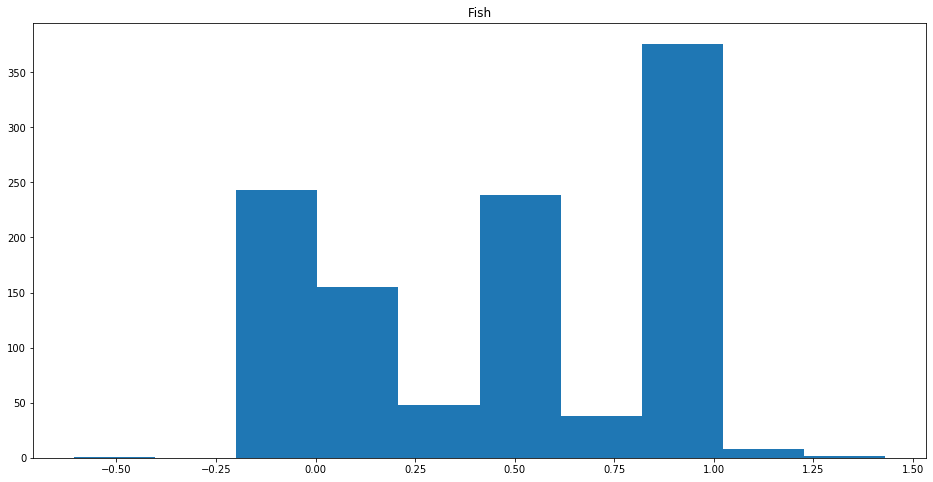

In [17]:
draw_prediction(prediction)

In [27]:
test["target"] = (prediction[0] >=1).astype("int8")
print (test[test["target"]>0][["EncodedPixels", "target"]].head(20))

                                           EncodedPixels  target
15144  136115 1019 137515 1019 138915 1019 140315 101...       1
21308                                                NaN       1
15540  538566 179 539966 179 541366 179 542766 179 54...       1
9132                                                 NaN       1
19476  1853664 562 1854227 66 1855064 629 1856464 629...       1
14744                                                NaN       1
1036   429846 842 431246 842 432646 842 434046 842 43...       1
19280                                                NaN       1
6300                                                 NaN       1
16296  300347 653 301747 653 303147 653 304547 653 30...       1
17492                                                NaN       1
9168   1410 223 2810 223 4210 223 5610 223 7010 223 8...       1
21892                                                NaN       1
10304                                                NaN       1
12360  1603080 585 160448

### Оценка по Дайсу
Пока будем считать, что при определении типа облака на изображении, оно целиком размещено на фотографии: т.е. область облака - это все изображение.

Нет облаков - 0.5, MLP - 0.5

In [28]:
dice = test.apply(calc_dice, axis=1, result_type="expand")
print ("Kers, (CONV3-32x2,POOL2):", round(dice.mean(), 3))

Kers, (CONV3-32x2,POOL2): 0.437
